**Import all modules and libraries needed**

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

**Give path to the drive and categorize data with labels**

In [ ]:
categories=['with_mask','without_mask']
data=[]
for category in categories:
  path=os.path.join('/content/drive/MyDrive/train',category)
  label=categories.index(category) #with_mask=0 without_mask=1
  for file in os.listdir(path):

    img_path=os.path.join(path,file)
    img=cv2.imread(img_path)
    img=cv2.resize(img,(224,224))

    data.append([img,label])


In [ ]:
len(data)

1376

In [ ]:
import random

In [ ]:
random.shuffle(data)

**Separate images and labels into separate lists**

In [ ]:
x=[]
y=[]

for features,label in data:
  x.append(features)
  y.append(label)

In [ ]:
x=np.array(x)
y=np.array(y)

In [ ]:
x.shape


(1376, 224, 224, 3)

In [ ]:
y.shape

(1376,)

In [ ]:
x=x/255

**Split the data into train and test**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [ ]:
x_train.shape

(1100, 224, 224, 3)

In [ ]:
x_test.shape

(276, 224, 224, 3)

**Import VGG16 architecture and use transfer learning to build your own model** 

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg=VGG16()

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import Sequential
model=Sequential()

In [ ]:
for layer in vgg.layers[:-1]:
  model.add(layer)

for layer in model.layers:
  layer.trainable=False
  

In [ ]:
# Adding dense layer with 1 outputs
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy']) 

#Lets look at the final model summary.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

**Train the model with train and test data***

In [ ]:
model.fit(x_train,y_train,epochs=6,validation_data=(x_test,y_test))

Epoch 1/6
35/35 [==============================] - 24s 311ms/step - loss: 0.5485 - accuracy: 0.7727 - val_loss: 0.3800 - val_accuracy: 0.9094
Epoch 2/6
35/35 [==============================] - 7s 201ms/step - loss: 0.3267 - accuracy: 0.9173 - val_loss: 0.2699 - val_accuracy: 0.9203
Epoch 3/6
35/35 [==============================] - 7s 203ms/step - loss: 0.2384 - accuracy: 0.9409 - val_loss: 0.2108 - val_accuracy: 0.9457
Epoch 4/6
35/35 [==============================] - 7s 208ms/step - loss: 0.1985 - accuracy: 0.9436 - val_loss: 0.1805 - val_accuracy: 0.9493
Epoch 5/6
35/35 [==============================] - 7s 213ms/step - loss: 0.1801 - accuracy: 0.9500 - val_loss: 0.1695 - val_accuracy: 0.9384
Epoch 6/6
35/35 [==============================] - 8s 218ms/step - loss: 0.1503 - accuracy: 0.9609 - val_loss: 0.1486 - val_accuracy: 0.9493


**Test the data with real time camera or other images**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


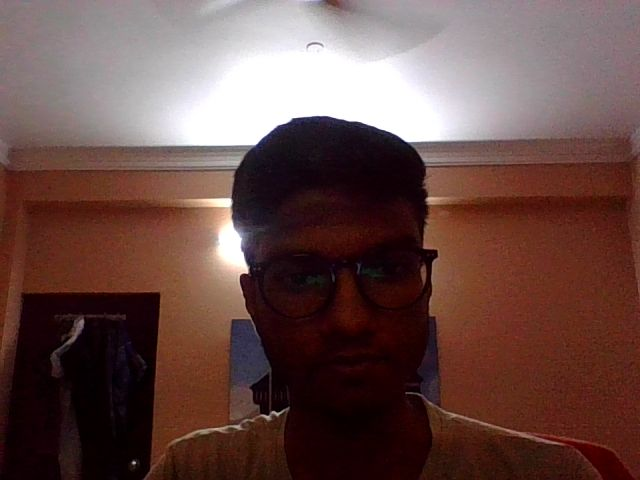

0.9999068


In [ ]:
from IPython.display import Image,display, clear_output
from google.colab.patches import cv2_imshow
import cv2 
from PIL import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  image = cv2.imread(filename)
  image=cv2.resize(image,(224,224))
  print(detect_face_mask(image))


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

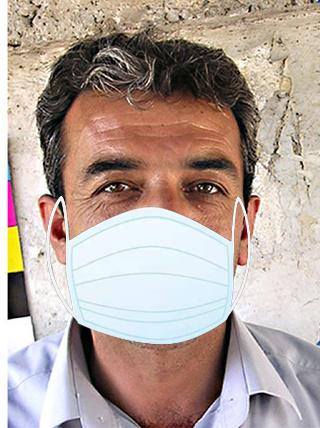

6.1833346e-22


In [ ]:

import cv2 
from PIL import Image
from IPython.display import display, clear_output


image = cv2.imread('/content/drive/MyDrive/train/with_mask/111-with-mask.jpg')

cv2_imshow(image)
image=cv2.resize(image,(224,224))
print(detect_face_mask(image))





In [ ]:
def detect_face_mask(img):
  y_pred=model.predict(img.reshape(1,224,224,3))
  # if y_pred[0][0]<0:
  #   return "Mask"
  # elif y_pred[0][0]>0.8:
  #   return "No Mask"
  return y_pred[0][0]
    